In [137]:
import MDAnalysis as MDA
import numpy as np
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

In [123]:
# Load Data here as MDA universe

U = MDA.Universe('md.5x5_mixed_PL_1.gro', 'md.5x5_network_test.xtc')
U.trajectory.rewind

<bound method ProtoReader.rewind of <XTCReader md.5x5_network_test.xtc with 101 frames of 247000 atoms>>

In [160]:
# Data structures

cluster_list = []
lipid_list = []
cluster_size = []
cluster_prob = []


In [161]:
def hdbscan_clustering(lip_coords, box_dims):
    dist = MDA.lib.distances.distance_array(lip_coords, lip_coords, box_dims)
# change min cluster size if necessary
    hdbscan_output = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5).fit(dist)
    cluster_list.append(hdbscan_output.labels_.max()+1)
    cluster_prob.append(hdbscan_output.probabilities_.mean())
# this step filters out all the <0 labels (unassigned lipids) and then averages over the number of clusters identified
# remember python 0 indexes these clusters so you have to add 1 to the number of labels to get the mean
    cluster_size.append((len(list(x for x in (hdbscan_output.labels_) if x>-1)))/((hdbscan_output.labels_.max()+1)))




In [162]:
# nb this currently fails if there are no contacts initially because it can't compute the distance matrix

pbar = tqdm(range(0, U.trajectory.n_frames))
for ts in U.trajectory:
    lipids_near_protein = U.select_atoms('resname PIP2 and name PO3 and around 45 (protein and resid 182)')
    lipid_list.append(lipids_near_protein.n_residues)
#    hdbscan_clustering(PI4P.atoms.positions, U.dimensions)
    hdbscan_clustering(lipids_near_protein.atoms.positions, U.dimensions)
    pbar.update(1)
    


(0, 400)

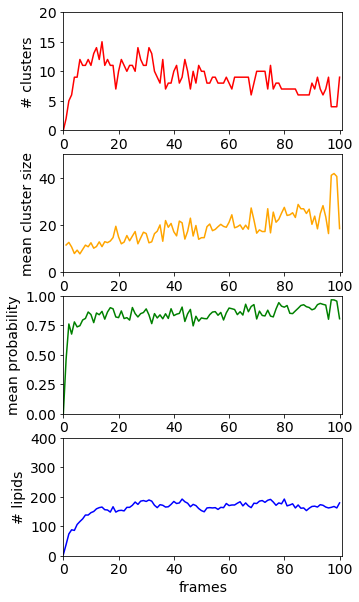

In [163]:
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(5,10))

plt.subplot(4,1,1)
plt.plot(cluster_list, color = 'red')
#plt.xlabel('frames')
plt.ylabel('# clusters')
plt.xlim(0,101)
plt.ylim(0,20)

plt.subplot(4,1,2)
plt.plot(cluster_size, color = 'orange')
#plt.xlabel('frames')
plt.ylabel('mean cluster size')
plt.ylim(0, 50)
plt.xlim(0,101)

plt.subplot(4,1,3)
plt.plot(cluster_prob, color = 'green')
#plt.xlabel('frames')
plt.ylabel('mean probability')
plt.xlim(0,101)
plt.ylim(0,1)

plt.subplot(4,1,4)
plt.plot(lipid_list, color = 'blue')
plt.xlabel('frames')
plt.ylabel('# lipids')
plt.xlim(0,101)
plt.ylim(0,400)